## Import Packages
Importing relevant packages for data ingestion, preprocessing, visualization and sentiment analysis.

In [1]:
import re
import swifter
import pandas as pd
import seaborn as sns
from langdetect import detect
import matplotlib.pyplot as plt
from transformers import pipeline

import warnings
warnings.simplefilter('ignore')

## Read Data
Read .csv file containing customer support tweets.

In [2]:
df = pd.read_csv('twcs.csv')
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


## Clean Data
Removes mentions, hashtags, URLs, special characters, and digits.

In [3]:
# Function to clean tweets
def clean_tweet(tweet):
    # Convert to lower case
    tweet = tweet.lower()
    # Remove mentions, hashtags, and URLs
    cleaned_tweet = re.sub(r'@\w+|#\w+|http\S+', '', tweet)
    # Remove special characters and digits
    cleaned_tweet = re.sub(r'[^\w\s]', '', cleaned_tweet)
    cleaned_tweet = re.sub(r'\d+', '', cleaned_tweet)
    return cleaned_tweet

# Clean the 'text' column
df['cleaned_text'] = df['text'].swifter.apply(clean_tweet)
df.to_csv('cleaned_tweets.csv', index=False)

Pandas Apply:   0%|          | 0/2811774 [00:00<?, ?it/s]

## Most Mentioned Authors
Extracting the list of top ten mentioned authors.

In [4]:
# Most mentioned authors
mentioned_authors = df[df['text'].str.contains('@')]['author_id'].value_counts().head(10)
print("Most Mentioned Authors:")
print(mentioned_authors)

Most Mentioned Authors:
AmazonHelp         169833
AppleSupport       106780
Uber_Support        56252
SpotifyCares        43257
Delta               42209
Tesco               38522
AmericanAir         36733
TMobileHelp         34314
comcastcares        33017
British_Airways     29323
Name: author_id, dtype: int64


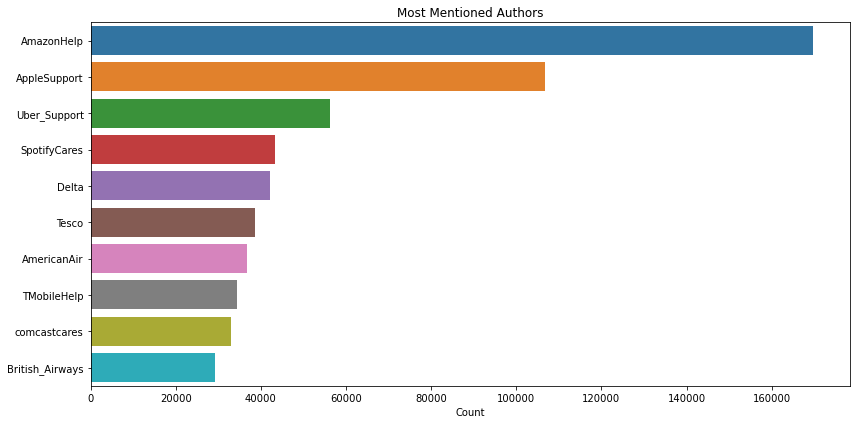

In [5]:
# Visualize patterns
plt.figure(figsize=(12, 6))

# Most mentioned authors plot
plt.subplot(1, 1, 1)
sns.barplot(x=mentioned_authors.values, y=mentioned_authors.index, orient='h')
plt.title("Most Mentioned Authors")
plt.xlabel("Count")

plt.tight_layout()
plt.show()

## Language Detection
We detect and analyze most used language by customers. To speedup the process, we will only focus on "Top Mentioned Author".

In [6]:
df_top = df[df['text'].str.contains('@AmazonHelp')]

In [9]:
def lang_detect(tweet):
    try:
        lang = detect(tweet)
        return lang
    except:
        return 'Unknown'

df_top['language'] = df_top['cleaned_text'].swifter.apply(lang_detect)
df_top.to_csv('clean_tweets_language.csv', index=False)
df_top.head()

Pandas Apply:   0%|          | 0/134747 [00:00<?, ?it/s]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,language
182,270,115770,True,Wed Nov 22 09:24:30 +0000 2017,@AmazonHelp ありがとうございます。\n今、電話で主人が対応していただいてます。,NaN,269.0,ありがとうございます\n今電話で主人が対応していただいてます,ja
183,271,115770,True,Wed Nov 22 09:30:36 +0000 2017,@AmazonHelp 電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎ...,273,269.0,電話で対応してもらいましたが改良されませんでした\n保証期間も過ぎてるので買い直しになるん...,ja
185,274,115770,True,Wed Nov 22 09:44:04 +0000 2017,@AmazonHelp こちらこそありがとうございました。,275,273.0,こちらこそありがとうございました,ja
322,616,115820,True,Tue Oct 31 23:22:08 +0000 2017,@AmazonHelp 3 different people have given 3 di...,618,615.0,different people have given different answe...,en
324,619,115820,True,Tue Oct 31 23:32:26 +0000 2017,@AmazonHelp I frankly don't have the patience ...,NaN,618.0,i frankly dont have the patience for another ...,en


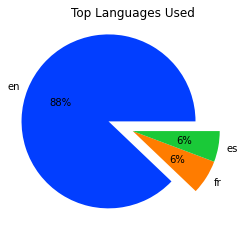

In [27]:
lang_data = dict(df_top['language'].value_counts()[:3])

# declaring data
keys = list(lang_data.keys())
data = list(lang_data.values())
  
# declaring exploding pie
explode = [0.3, 0, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
  
# displaying chart
plt.title("Top Languages Used")
plt.show()

## Sentiment Analysis
Since our data is unlabelled, we will utilize a pre-trained model. We'll only focus on english tweets as of now.

In [29]:
df_eng = df_top[df_top['language']=='en']
df_eng.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,language
322,616,115820,True,Tue Oct 31 23:22:08 +0000 2017,@AmazonHelp 3 different people have given 3 di...,618,615.0,different people have given different answe...,en
324,619,115820,True,Tue Oct 31 23:32:26 +0000 2017,@AmazonHelp I frankly don't have the patience ...,NaN,618.0,i frankly dont have the patience for another ...,en
333,627,115827,True,Wed Nov 01 12:50:18 +0000 2017,@AmazonHelp @115826 Yeah this is crazy we’re l...,629,626.0,yeah this is crazy were less than a week awa...,en
340,634,115831,True,Tue Oct 31 21:39:58 +0000 2017,@115821 @AmazonHelp why is my order at my loca...,633,NaN,why is my order at my local courier for the ...,en
344,638,115834,True,Tue Oct 31 22:19:56 +0000 2017,@AmazonHelp Hi ready for some help,637,639.0,hi ready for some help,en


In [30]:
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def get_sentiment(tweet):
    sentiment = sentiment_task(tweet)[0]['label']
    return sentiment

df_eng['sentiment'] = df_eng['cleaned_text'].swifter.apply(get_sentiment)
df_eng.to_csv('clean_tweets_language_sentiment.csv', index=False)
df_eng.head()

Pandas Apply:   0%|          | 0/100888 [00:00<?, ?it/s]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,language,sentiment
322,616,115820,True,Tue Oct 31 23:22:08 +0000 2017,@AmazonHelp 3 different people have given 3 di...,618,615.0,different people have given different answe...,en,negative
324,619,115820,True,Tue Oct 31 23:32:26 +0000 2017,@AmazonHelp I frankly don't have the patience ...,NaN,618.0,i frankly dont have the patience for another ...,en,negative
333,627,115827,True,Wed Nov 01 12:50:18 +0000 2017,@AmazonHelp @115826 Yeah this is crazy we’re l...,629,626.0,yeah this is crazy were less than a week awa...,en,negative
340,634,115831,True,Tue Oct 31 21:39:58 +0000 2017,@115821 @AmazonHelp why is my order at my loca...,633,NaN,why is my order at my local courier for the ...,en,negative
344,638,115834,True,Tue Oct 31 22:19:56 +0000 2017,@AmazonHelp Hi ready for some help,637,639.0,hi ready for some help,en,neutral


Check few random rows to see performance of the model

In [47]:
pd.set_option('display.max_colwidth', None)

In [51]:
df_eng.sample(n=14)[['text', 'sentiment']]

,text,sentiment
24375,@AmazonHelp Are you going to respond?,neutral
98950,@AmazonHelp Thank you I’ll check the link right now,positive
51474,@AmazonHelp Yes. That would allow me on a per order basis to be unhappy with the timeliness of delivery.,negative
35465,@AmazonHelp It's not working I told u.what is ur problem I share screenshot of my order chk it and revert,negative
86594,@AmazonHelp Learned my delivery promised for today did not deliver and you signed me up for some remote UPS dump off service that I neither authorized nor requested (fraud?). My package did not arrive on the date promised. Long phone call w/Amazon+UPS; no resolution yet.,negative
76230,@AmazonHelp The delivery date given was today 10th November,neutral
582,@AmazonHelp Its not my issue for return pick up. U people not mention any where before purchase product otherwise i think about purchase this order.,negative
26163,@AmazonHelp And the same seller.,neutral
37965,@AmazonHelp Fuming. Prime expediated delivery. 2 days late. Open box and item been swapped. Now have to wait until monday for replacement! https://t.co/rmeAyH0Qxi,negative
45524,"@AmazonHelp Seriously, I don't have time. I worked for whole day and now it's time for some sleep.",negative


## Bonus
Sentiments of text over time using temporal analysis.

<Figure size 864x432 with 0 Axes>

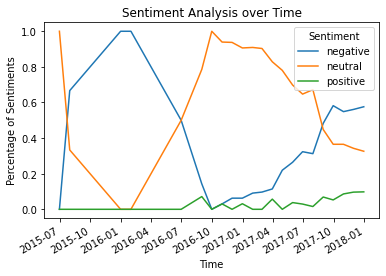

In [42]:
# Convert the 'created_at' column to datetime
df_eng['created_at'] = pd.to_datetime(df_eng['created_at'])

# Set the 'created_at' column as the DataFrame index
df_eng.set_index('created_at', inplace=True)

# Define the time interval for grouping (e.g., monthly)
interval = 'M'

# Group the tweets into the defined time interval and calculate sentiment statistics
sentiment_stats = df_eng.groupby(pd.Grouper(freq=interval))['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Plot the sentiment statistics over time
plt.figure(figsize=(12, 6))
sentiment_stats.plot()
plt.xlabel('Time')
plt.ylabel('Percentage of Sentiments')
plt.title('Sentiment Analysis over Time')
plt.legend(title='Sentiment')
plt.show()